In [1]:
import numpy as np
import pandas as pd
from scipy.misc import derivative
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
N = 4
INF = 10 ** 6
I = 1000

x0 = np.zeros(N)
h0 = np.zeros(N)

p = [20, 20, 20, 20] # initial points

# plot configuration
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = 8, 5

# Part I

### My function

$ U(x) = (x_{1}-7)^{0.25}(x_{2}-17)^{0.09}x^{0.3}_{3}(x_{4}-2)^{0.2} $

In [3]:
def U(x1, x2, x3, x4):
    return (x1 - 7) ** 0.25 * (x2 - 17) ** 0.09 * x3 ** 0.3 * (x4 - 2) ** 0.2


def partial_derivative(func, var=0, point=[]):
    args = point[:]

    def wraps(x):
        args[var] = x
        return func(*args)

    return derivative(wraps, point[var], dx = 1e-6)

## Marshall

In [4]:
def objective_m(x):
    return - U(x[0], x[1], x[2], x[3])


def constraint1(x):
    return I - x[0] * p[0] - x[1] * p[1] - x[2] * p[2] - x[3] * p[3]


x0[0] = 9 # initial x-vector
x0[1] = 20
x0[2] = 9
x0[3] = 10

bnds = (
    (7, INF),
    (17, INF),
    (0, INF),
    (2, INF)
)

con1 = {'type': 'ineq', 'fun': constraint1}
cons = ([con1])
solution = minimize(objective_m, x0, method='SLSQP', bounds=bnds, constraints=cons)

x = solution.x

print('Final Objective: ' + str(-objective_m(x)))

print('\nSolution')
for i in range(4):
    print('x{} = {}'.format(i + 1, x[i]))
    
print("\nLagrange multiplier")
L = [partial_derivative(U, i, x) / p[i] for i in range(4)]
for i in range(4):
    print('L{} = {}'.format(i + 1, L[i]))

Final Objective: 4.80498489644

Solution
x1 = 14.140279462615863
x2 = 19.570974676129996
x3 = 8.575006773194632
x4 = 7.713739088059505

Lagrange multiplier
L1 = 0.008411759155890763
L2 = 0.008410208418574427
L3 = 0.008405215323747939
L4 = 0.008409528917674436


## Hiks

In [5]:
def objective_h(h):
    return p[0] * h[0] + p[1] * h[1] + p[2] * h[2] + p[3] * h[3]


def constraint1(h):
    return U(h[0], h[1], h[2], h[3]) - 200


h0[0] = 9 # initial h-vector
h0[1] = 20
h0[2] = 9
h0[3] = 10

bnds = (
    (7, INF),
    (17, INF),
    (0, INF),
    (2, INF)
)

con1 = {'type': 'ineq', 'fun': constraint1}
cons = ([con1])
solution = minimize(objective_h, h0, method='SLSQP', bounds=bnds, constraints=cons)

h = solution.x

print('Final Objective: ' + str(objective_h(h)))

print('\nSolution')
for i in range(len(h)):
    print('h{} = {}'.format(i + 1, h[i]))
print('U(h) = {}'.format(U(h[0], h[1], h[2], h[3])))

print("\nLagrange multiplier")
L = [p[i] / partial_derivative(U, i, h) for i in range(4)]
for i in range(4):
    print('L{} = {}'.format(i + 1, L[i]))

Final Objective: 41166.6268386

Solution
h1 = 611.8566384737018
h2 = 234.74952920994335
h3 = 725.8345065912623
h4 = 485.8906676551041
U(h) = 200.00000000000225

Lagrange multiplier
L1 = 241.94265914293283
L2 = 241.9439901104927
L3 = 241.94486356591216
L4 = 241.94536268612626


# Part II

The volume of production capital (fixed assets) K and the volume of labor L, which are measured: <br>for K - in monetary or natural terms, <br>for L - in the number of workers, man-hours, man-days, etc.

### Uploading data

In [6]:
data = pd.read_csv('lab3_data.csv')
data

,K,L,F
0,2660,10380,49420
1,2720,10210,45250
2,2740,10370,50050
3,2650,10500,50070
4,2320,9750,47320
5,2490,10100,47400
6,2770,10620,51400
7,2610,10380,45470
8,2800,9600,47530
9,2880,9570,47600


In [7]:
K = data['K'].values
L = data['L'].values
F = data['F'].values

## Production func., scales and elasticity

In [8]:
def cobb_douglas(x, a, b, c):
    return a * (x[0] ** b) * (x[1] ** c)

#def linear_approx(x, a, b, c):
#    return a + x[0] * b + x[1] * c


p0 = [1, 1, 1]
coeffs, _ = curve_fit(cobb_douglas, (K, L) , F, p0)

print("Production function F = {} * K ^ {} * L ^ {}".format(coeffs[0], coeffs[1], coeffs[2]))

if abs(coeffs[1] + coeffs[2] - 1) < 1e-3:
    print('Constant returns to scale')
elif coeffs[1] + coeffs[2] > 1:
    print('Increasing returns to scale')
else:
    print('Decreasing returns to scale')

print('Elasticity of substitution for Cobb–Douglas production function is const=1')

Production function F = 141.69191034852955 * K ^ 0.15111129031060572 * L ^ 0.5026447942457296
Decreasing returns to scale
Elasticity of substitution for Cobb–Douglas production function is const=1


In [9]:
#for i in range(0, 9):
#    print(abs(coeffs[0] * (K[i] ** coeffs[1]) * (L[i] ** coeffs[2]) - F[i]))

### Visualization

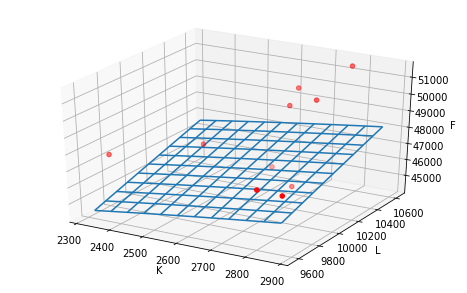

In [10]:
def makeData():
    x = np.arange (2320, 2880, 50)
    y = np.arange (9600, 10620, 100)
    xgrid, ygrid = np.meshgrid(x, y)
    zgrid = 141.7 * np.power(xgrid, 0.15) * np.power(ygrid, 0.5)
    return xgrid, ygrid, zgrid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = makeData()
ax.plot_wireframe(x, y, z)

ax.scatter(K, L, F, color='r')

ax.set_xlabel('K')
ax.set_ylabel('L')
ax.set_zlabel('F')

plt.show()

## Short-run & long-run profits

In [11]:
price = 70
w = [100, 100]


def pi(x):
    return w[0] * x[0] + w[1] * x[1] - price * cobb_douglas(x, coeffs[0], coeffs[1], coeffs[2])

def constraint1(x):  # sqrt(x[0] * x[0] + x[1] * x[1]) <= 5000
    return 5000 - (x[0] * x[0] + x[1] * x[1]) ** 0.5


bounds1 = (
    (0, INF),
    (0, INF)
)

long_solution = minimize(pi, [1, 1], method='SLSQP', bounds=bounds1, constraints=[])
print('Solution')
x = long_solution.x
for i in range(len(x)):
    print('x{} = {}'.format(i + 1, x[i]))
print("Long run profit is", -pi(long_solution.x))
print()

con1 = {'type': 'ineq', 'fun': constraint1}
short_solution = minimize(pi, [1, 1], method='SLSQP', bounds=bounds1, constraints=[con1])
print('Solution')
x = short_solution.x
for i in range(len(x)):
    print('x{} = {}'.format(i + 1, x[i]))
print("Short run profit is", -pi(short_solution.x))

Solution
x1 = 14240.574014870512
x2 = 47367.09422920981
Long run profit is 3262295.00062

Solution
x1 = 2028.6739748934274
x2 = 4569.954256679813
Short run profit is 1507022.09882


## Monopoly profit/price (of resources) and the volume of production

In [12]:
def price_func(x):
    return -x / 830 + 8310/83


def wL(x):
    return 0.025 * x[1] - 20


def wK(x):
    return 0.025 * x[0] - 10


def wM(x):
    return (wK(x), wL(x))


def monopoly_pi(x):
    q = cobb_douglas(x, coeffs[0], coeffs[1], coeffs[2])
    mw = wM(x)
    return mw[0] * x[0] + mw[1] * x[1] - price_func(q) * q


monopoly_solution = minimize(monopoly_pi, [1, 1], method='SLSQP', bounds=bounds1, constraints=[])
print('Solution')
x = monopoly_solution.x
for i in range(len(x)):
    print('x{} = {}'.format(i + 1, x[i]))
print("Monopoly profit is", -monopoly_pi(monopoly_solution.x))
print("Monopoly price is", price_func(cobb_douglas(monopoly_solution.x, coeffs[0], coeffs[1], coeffs[2])))
print("Monopoly price of resources: K = {}, L = {}".format(wK(monopoly_solution.x), wL(monopoly_solution.x)))
print("Volume of production is", cobb_douglas(monopoly_solution.x, coeffs[0], coeffs[1], coeffs[2]))

Solution
x1 = 1819.053345464246
x2 = 3336.1107202697835
Monopoly profit is 1512419.97127
Monopoly price is 68.8016982418
Monopoly price of resources: K = 35.47633363660615, L = 63.402768006744594
Volume of production is 25994.5904593
